In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy.stats import norm, t

In [2]:
df = pd.read_csv("/home/hujianjin/projects/LinearRegression_XAUUSD/price_data.csv")



In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df = df.set_index('Date')

In [5]:
df

,Open,High,Low,Close,Tick_Vol
Date,,,,,
2020-01-05,1558.650,1611.25,1540.170,1562.03,417142
2020-01-12,1559.911,1561.44,1535.850,1557.00,288879
2020-01-19,1557.520,1575.73,1546.290,1571.42,263672
2020-01-26,1581.140,1590.29,1563.305,1589.20,368721
2020-02-02,1590.810,1591.88,1547.440,1570.07,347703
...,...,...,...,...,...
2025-05-25,3354.940,3356.54,3245.190,3288.34,1068819
2025-06-01,3298.240,3403.46,3295.220,3309.83,1182423
2025-06-08,3310.530,3446.75,3293.460,3431.88,1159543


In [6]:
# 3-week average
df['SMA_3'] = df['Close'].rolling(window=3).mean()
# 5-week average
df['SMA_5'] = df['Close'].rolling(window=5).mean()
# Short vs long trend signal (3-week vs 5-week)
df['SMA_diff'] = df['SMA_3'] - df['SMA_5']             


In [7]:
# 1-week momentum (current - previous)
df['Momentum_1w'] = df['Close'] - df['Close'].shift(1)
# 2-week momentum (current - 2 weeks ago)
df['Momentum_2w'] = df['Close'] - df['Close'].shift(2)
# % change vs previous week (current - previous) / previous
df['Pct_Change_1w'] = df['Close'].pct_change(periods=1)


In [8]:
# 3-week closing price volatility (std deviation of last 3 weeks)
df['Volatility_3w'] = df['Close'].rolling(window=3).std()


In [9]:
# weekly range
df['Range'] = df['High'] - df['Low']
# weekly range ratio (range / open price)
df['Range_ratio'] = df['Range'] / df['Open']


In [10]:
# Last week's close
df['Close_lag1'] = df['Close'].shift(1) 
# 2 weeks ago close
df['Close_lag2'] = df['Close'].shift(2)


In [11]:
# weekly Close to Open ratio
df['Close_Open_ratio'] = df['Close'] / df['Open']

# weekly Volume Change (current - previous)
df['Volume_Change'] = df['Tick_Vol'] - df['Tick_Vol'].shift(1)

# weekly Volatility
df['Volatility'] = (df['High'] - df['Low']) / df['Open']

# weekly Volatility normalized by tick volume
df['Volatility_per_Tick'] = df['Volatility'] / df['Tick_Vol']



In [12]:
df['Low_next_week'] = df['Low'].shift(-1)

In [13]:
df

,Open,High,Low,Close,Tick_Vol,SMA_3,SMA_5,SMA_diff,Momentum_1w,Momentum_2w,...,Volatility_3w,Range,Range_ratio,Close_lag1,Close_lag2,Close_Open_ratio,Volume_Change,Volatility,Volatility_per_Tick,Low_next_week
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-05,1558.650,1611.25,1540.170,1562.03,417142,NaN,NaN,NaN,NaN,NaN,...,NaN,71.080,0.045604,NaN,NaN,1.002169,NaN,0.045604,1.093238e-07,1535.850
2020-01-12,1559.911,1561.44,1535.850,1557.00,288879,NaN,NaN,NaN,-5.03,NaN,...,NaN,25.590,0.016405,1562.03,NaN,0.998134,-128263.0,0.016405,5.678773e-08,1546.290
2020-01-19,1557.520,1575.73,1546.290,1571.42,263672,1563.483333,NaN,NaN,14.42,9.39,...,7.319032,29.440,0.018902,1557.00,1562.03,1.008924,-25207.0,0.018902,7.168696e-08,1563.305
2020-01-26,1581.140,1590.29,1563.305,1589.20,368721,1572.540000,NaN,NaN,17.78,32.20,...,16.129191,26.985,0.017067,1571.42,1557.00,1.005098,105049.0,0.017067,4.628649e-08,1547.440
2020-02-02,1590.810,1591.88,1547.440,1570.07,347703,1576.896667,1569.944,6.952667,-19.13,-1.35,...,10.676359,44.440,0.027935,1589.20,1571.42,0.986963,-21018.0,0.027935,8.034286e-08,1561.830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-25,3354.940,3356.54,3245.190,3288.34,1068819,3281.773333,3280.814,0.959333,-67.48,87.18,...,77.538827,111.350,0.033190,3355.82,3201.16,0.980149,-125606.0,0.033190,3.105284e-08,3295.220
2025-06-01,3298.240,3403.46,3295.220,3309.83,1182423,3317.996667,3295.504,22.492667,21.49,-45.99,...,34.473300,108.240,0.032818,3288.34,3355.82,1.003514,113604.0,0.032818,2.775445e-08,3293.460
2025-06-08,3310.530,3446.75,3293.460,3431.88,1159543,3343.350000,3317.406,25.944000,122.05,143.54,...,77.418510,153.290,0.046304,3309.83,3288.34,1.036656,-22880.0,0.046304,3.993277e-08,3340.270


In [14]:
# Drop unnecessary columns and rows with NaN values
df1 = (
    df.drop(
        columns=[
            'Open', 'High', 'Low', 'Close', 'Tick_Vol'
        ],
        axis=1
    )
    .dropna()
)
df1

,SMA_3,SMA_5,SMA_diff,Momentum_1w,Momentum_2w,Pct_Change_1w,Volatility_3w,Range,Range_ratio,Close_lag1,Close_lag2,Close_Open_ratio,Volume_Change,Volatility,Volatility_per_Tick,Low_next_week
Date,,,,,,,,,,,,,,,,
2020-02-02,1576.896667,1569.944,6.952667,-19.13,-1.35,-0.012038,10.676359,44.44,0.027935,1589.20,1571.42,0.986963,-21018.0,0.027935,8.034286e-08,1561.83
2020-02-09,1580.926667,1574.240,6.686667,13.44,-5.69,0.008560,9.823158,23.08,0.014686,1570.07,1589.20,1.007578,-74435.0,0.014686,5.374091e-08,1578.80
2020-02-16,1598.883333,1591.454,7.429333,59.56,73.00,0.037613,38.852343,70.32,0.044447,1583.51,1570.07,1.038537,33097.0,0.044447,1.450794e-07,1562.76
2020-02-23,1604.033333,1594.274,9.759333,-57.55,2.01,-0.035026,33.821680,126.49,0.076510,1643.07,1583.51,0.959032,342761.0,0.076510,1.178660e-07,1575.28
2020-03-01,1633.966667,1611.096,22.870667,87.79,30.24,0.055370,44.597355,116.65,0.073311,1585.52,1643.07,1.051622,-94911.0,0.073311,1.322787e-07,1504.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-18,3293.116667,3286.262,6.854667,154.66,33.45,0.048314,81.374118,161.53,0.050235,3201.16,3322.37,1.043645,-119125.0,0.050235,4.205799e-08,3245.19
2025-05-25,3281.773333,3280.814,0.959333,-67.48,87.18,-0.020108,77.538827,111.35,0.033190,3355.82,3201.16,0.980149,-125606.0,0.033190,3.105284e-08,3295.22
2025-06-01,3317.996667,3295.504,22.492667,21.49,-45.99,0.006535,34.473300,108.24,0.032818,3288.34,3355.82,1.003514,113604.0,0.032818,2.775445e-08,3293.46


In [15]:
# Retrieve the last row of the DataFrame
df2 = (
    df[-1:].drop(
        columns=[
            'Open', 'High', 'Low', 'Close', 'Tick_Vol'
        ],
        axis=1
    )
)
df2

,SMA_3,SMA_5,SMA_diff,Momentum_1w,Momentum_2w,Pct_Change_1w,Volatility_3w,Range,Range_ratio,Close_lag1,Close_lag2,Close_Open_ratio,Volume_Change,Volatility,Volatility_per_Tick,Low_next_week
Date,,,,,,,,,,,,,,,,
2025-06-22,3356.586667,3333.586,23.000667,-97.98,-161.93,-0.029092,81.55878,140.83,0.041565,3367.93,3431.88,0.965108,21705.0,0.041565,4.212556e-08,NaN


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281 entries, 2020-02-02 to 2025-06-15
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SMA_3                281 non-null    float64
 1   SMA_5                281 non-null    float64
 2   SMA_diff             281 non-null    float64
 3   Momentum_1w          281 non-null    float64
 4   Momentum_2w          281 non-null    float64
 5   Pct_Change_1w        281 non-null    float64
 6   Volatility_3w        281 non-null    float64
 7   Range                281 non-null    float64
 8   Range_ratio          281 non-null    float64
 9   Close_lag1           281 non-null    float64
 10  Close_lag2           281 non-null    float64
 11  Close_Open_ratio     281 non-null    float64
 12  Volume_Change        281 non-null    float64
 13  Volatility           281 non-null    float64
 14  Volatility_per_Tick  281 non-null    float64
 15  Low_next_week        

In [17]:
# Feature Engineering
features = [
    'SMA_3', 'SMA_5', 'SMA_diff',
    'Momentum_1w', 'Momentum_2w', 'Pct_Change_1w',
    'Volatility_3w', 'Range', 'Range_ratio',
    'Close_lag1', 'Close_lag2', 'Close_Open_ratio',
    'Volume_Change', 'Volatility', 'Volatility_per_Tick'
]

In [18]:
# Select features and target values
X = df1[features].values
y = df1['Low_next_week'].values

In [19]:
# Final Holdout Split (80% train, 20% test)
split_index = int(len(X) * 0.8)

X_train_full, X_test = X[:split_index], X[split_index:]
y_train_full, y_test = y[:split_index], y[split_index:]

In [20]:
# Display basic information about the datasets
print(f"X_train_full shape: {X_train_full.shape}")
print(f"y_train_full shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_shape: {y_test.shape}")

X_train_full shape: (224, 15)
y_train_full shape: (224,)
X_test shape: (57, 15)
y_test_shape: (57,)


In [21]:
# Scale numeric features
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Initialize TimeSeriesSplit for model evaluation only
# no hyperparameter tuning in this example
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store scores
mae_scores = []
mse_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

# Time series cross-validation loop
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full_scaled)):
    X_train_scaled, X_val_scaled = X_train_full_scaled[train_idx], X_train_full_scaled[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)

    # Compute metrics
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)*100
    r2 = r2_score(y_val, y_val_pred)

    # Store scores
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    r2_scores.append(r2)

    print(f"Fold {fold + 1}: MAE = {mae:.4f}, MSE = {mse:.4f}, RMSE = {rmse:.4f}, MAPE = {mape:.4f}, R² = {r2:.4f}")

# Print average scores
print("\nAverage CV Scores:")
print(f"MAE:  {np.mean(mae_scores):.4f}")
print(f"MSE:  {np.mean(mse_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f}")
print(f"MAPE: {np.mean(mape_scores):.4f}")
print(f"R²:   {np.mean(r2_scores):.4f}")


Fold 1: MAE = 33.1150, MSE = 1541.5355, RMSE = 39.2624, MAPE = 1.8615, R² = 0.4887
Fold 2: MAE = 25.2491, MSE = 1094.7600, RMSE = 33.0872, MAPE = 1.4167, R² = 0.7463
Fold 3: MAE = 22.7527, MSE = 877.2202, RMSE = 29.6179, MAPE = 1.3049, R² = 0.8724
Fold 4: MAE = 25.8948, MSE = 845.3413, RMSE = 29.0748, MAPE = 1.3562, R² = 0.7027
Fold 5: MAE = 25.1847, MSE = 852.7179, RMSE = 29.2013, MAPE = 1.2157, R² = 0.9610

Average CV Scores:
MAE:  26.4392
MSE:  1042.3150
RMSE: 32.0487
MAPE: 1.4310
R²:   0.7542


In [23]:
# Fit model on Full Training Set
model.fit(X_train_full_scaled, y_train_full)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [24]:
# Prediction on full training set
y_train_full_pred = model.predict(X_train_full_scaled)

In [25]:
# Prediction on Test Set
y_test_pred = model.predict(X_test_scaled)

In [26]:
results = pd.DataFrame({
    "predicted": y_test_pred,          # model's predicted low price
    "actual": y_test                   # actual low prices
})
print(results)

      predicted    actual
0   2312.676312  2320.429
1   2280.994293  2286.610
2   2270.697117  2287.609
3   2291.616002  2306.499
4   2285.855154  2293.489
5   2286.738039  2318.417
6   2341.815866  2349.309
7   2370.508406  2393.670
8   2363.829141  2353.030
9   2346.971235  2369.559
10  2403.186606  2364.206
11  2398.646671  2423.699
12  2448.565424  2470.799
13  2467.687200  2493.539
14  2451.272642  2471.758
15  2453.365709  2485.429
16  2528.059910  2546.779
17  2573.075916  2613.739
18  2603.120237  2624.569
19  2596.924651  2600.589
20  2607.105197  2637.990
21  2663.863314  2708.720
22  2691.529108  2724.619
23  2680.014962  2644.690
24  2653.273233  2537.650
25  2555.203831  2560.790
26  2663.855016  2606.199
27  2632.726518  2614.030
28  2583.230182  2627.695
29  2605.127018  2581.689
30  2587.598283  2608.300
31  2563.804303  2596.129
32  2594.648383  2615.544
33  2642.239976  2656.760
34  2651.677369  2689.345
35  2710.995053  2730.834
36  2742.247716  2772.100
37  2803.838

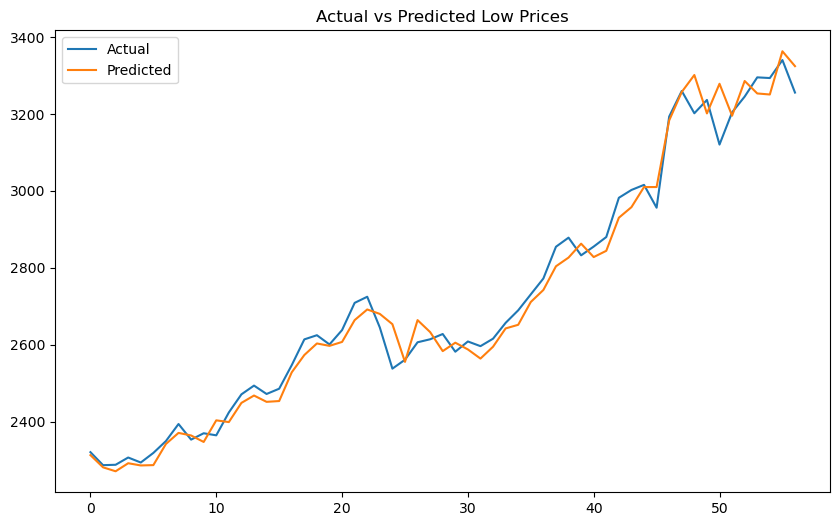

In [27]:
# Plot actual vs predicted line chart on test data
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title("Actual vs Predicted Low Prices")
plt.legend()
plt.show()

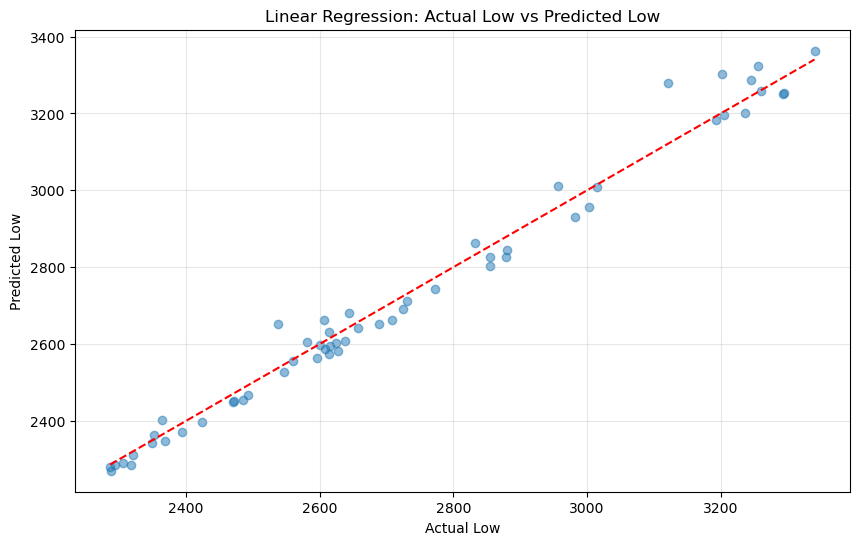

In [28]:
# Plot actual vs predicted scatter plot on test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Low')
plt.ylabel('Predicted Low')
plt.title('Linear Regression: Actual Low vs Predicted Low')
plt.grid(True, alpha=0.3)

In [29]:
# Compute performance metrics on test data

model_test_mae = mean_absolute_error(y_test, y_test_pred)
model_test_mse = mean_squared_error(y_test, y_test_pred)
model_test_rmse = np.sqrt(model_test_mse)
model_test_mape = mean_absolute_percentage_error(y_test, y_test_pred)*100
model_test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Linear Regression Performance on Test Data:")
print(f"Model - MAE:  {model_test_mae:.4f}")
print(f"        MSE:  {model_test_mse:.4f}")
print(f"        RMSE: {model_test_rmse:.4f}")
print(f"        MAPE: {model_test_mape:.4f}")
print(f"        R²:   {model_test_r2:.4f}")

Linear Regression Performance on Test Data:
Model - MAE:  32.7373
        MSE:  1797.6611
        RMSE: 42.3988
        MAPE: 1.1797
        R²:   0.9818


In [30]:
# retrieve the last row of the DataFrame
df2

,SMA_3,SMA_5,SMA_diff,Momentum_1w,Momentum_2w,Pct_Change_1w,Volatility_3w,Range,Range_ratio,Close_lag1,Close_lag2,Close_Open_ratio,Volume_Change,Volatility,Volatility_per_Tick,Low_next_week
Date,,,,,,,,,,,,,,,,
2025-06-22,3356.586667,3333.586,23.000667,-97.98,-161.93,-0.029092,81.55878,140.83,0.041565,3367.93,3431.88,0.965108,21705.0,0.041565,4.212556e-08,NaN


In [31]:
# Select last row features
X_last = df2[features]

In [32]:
# Scale the last row features using the previously fitted scaler
X_last_scaled = scaler.transform(X_last)

/home/hujianjin/miniconda3/envs/forecasting_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [33]:
# Predict the next week's low price
predicted_next = model.predict(X_last_scaled)

# Extract scalar values from the prediction
predicted_next = predicted_next[0]


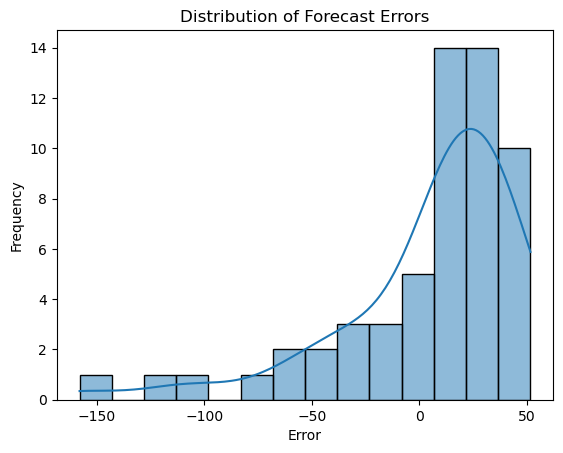

In [34]:
# Histogram + density curve of forecast errors
errors = y_test - y_test_pred  # residuals/errors
sns.histplot(errors, kde=True)
plt.title("Distribution of Forecast Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

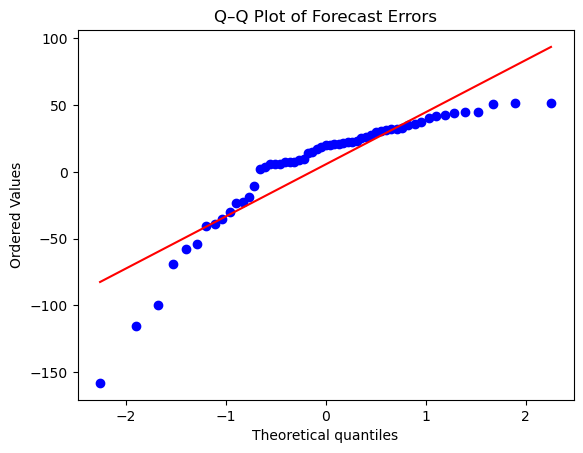

In [35]:
# Q–Q Plot of forecast errors
stats.probplot(errors, dist="norm", plot=plt)
plt.title("Q–Q Plot of Forecast Errors")
plt.show()

In [36]:
# errors = y_test - y_test_pred

# 1. Mean and standard deviation
mean_err = np.mean(errors)
std_err = np.std(errors, ddof=1)  # sample standard deviation

# 2. Symmetric ±1σ range around the mean
lower = mean_err - std_err
upper = mean_err + std_err

# 3. Percentage of errors within this range
within_range = np.mean((errors >= lower) & (errors <= upper)) * 100

print(f"Mean error: {mean_err:.4f}")
print(f"Std deviation: {std_err:.4f}")
print(f"±1σ range: {lower:.4f} to {upper:.4f}")
print(f"Coverage: {within_range:.2f}% of errors fall within ±1σ")


Mean error: 5.5699
Std deviation: 42.4050
±1σ range: -36.8351 to 47.9749
Coverage: 80.70% of errors fall within ±1σ


In [37]:
# Empirical 68% range using percentiles

lower_q = np.percentile(errors, 16)  # 16th percentile
upper_q = np.percentile(errors, 84)  # 84th percentile

print(f"68% empirical range of errors: {lower_q:.2f} to {upper_q:.2f}")


68% empirical range of errors: -30.48 to 37.79


In [38]:
# Empirical 68% range for actual price prediction
predicted_price = 3245.0963
lower_bound = predicted_price + lower_q
upper_bound = predicted_price + upper_q

print(f"Predicted <2025-06-29> Low Price: {predicted_next:.4f}")
print(f"68% empirical range for actual low price: {lower_bound:.2f} – {upper_bound:.2f}")


Predicted <2025-06-29> Low Price: 3245.0963
68% empirical range for actual low price: 3214.61 – 3282.88
